# Importing Libraries

In [39]:
import tensorflow as tf
import pandas as pd


In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Loading MNIST Dataset

In [4]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

### Splitting data into test and train

In [40]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [6]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

In [7]:

def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

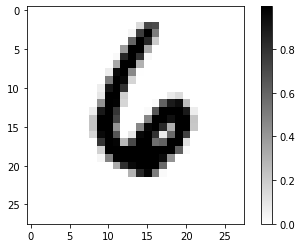

In [14]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image 
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

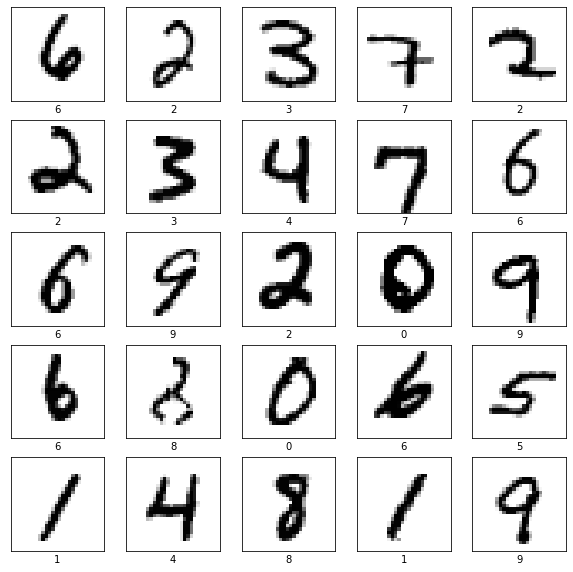

In [15]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# Defining Model

In [16]:

# Model with 2 convolution layers and 2 max-pooling layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



In [18]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [19]:
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1199 - accuracy: 0.9628


In [20]:
model.save('my_model') 

In [21]:
model = tf.keras.models.load_model('my_model')

# Check its architecture
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)


313/313 [==============================] - 2s 7ms/step - loss: 0.0397 - accuracy: 0.9857
Accuracy on test dataset: 0.9857


In [41]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)


In [42]:
model = tf.keras.models.load_model('model_weight.h5')

In [43]:
predictions.shape

(32, 10)

In [44]:
predictions[0]

array([1.00091565e-05, 2.98454381e-08, 3.56758648e-07, 4.44778792e-08,
       1.24437374e-05, 3.94523749e-06, 9.99971747e-01, 9.08134794e-08,
       1.21624657e-06, 1.02379502e-07], dtype=float32)

In [45]:
np.argmax(predictions[0])

6

In [46]:
test_labels[0]

6

In [47]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
  
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
    

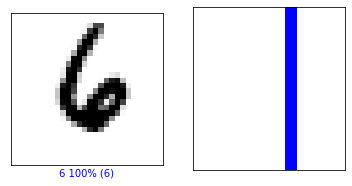

In [48]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)




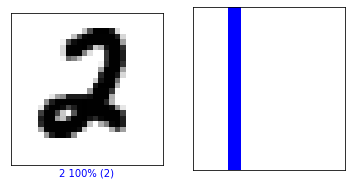

In [31]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

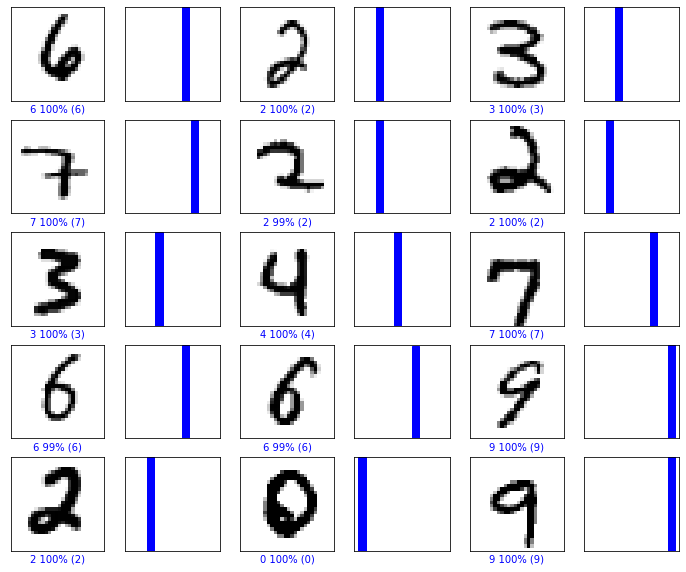

In [32]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [33]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [34]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [35]:
predictions_single = model.predict(img)

print(predictions_single)



[[1.0009128e-05 2.9845381e-08 3.5675797e-07 4.4477794e-08 1.2443702e-05
  3.9452302e-06 9.9997175e-01 9.0813138e-08 1.2162430e-06 1.0237950e-07]]


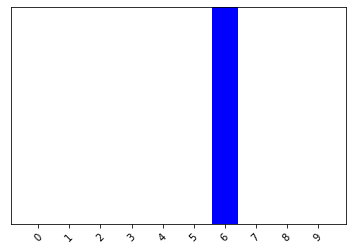

In [36]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)






In [37]:
np.argmax(predictions_single[0])

6

In [38]:
import cv2
import numpy as np
import pandas as pd


cap = cv2.VideoCapture(0)
while (cap.isOpened()):
    ret , img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting to grayscale

    
    #thresholding
    ret, thresh = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    x, y, w, h = 0, 0, 200, 200
    thresh  = thresh[y:y + h, x:x + w]
    cv2.imshow("t", thresh)

    Captured_Image = cv2.resize(thresh, (28,28)) #resizing in 28 * 28 shape
    Captured_Image = np.array(Captured_Image)/255  # creating numpy array an dividing by 255 to normalise
    Captured_Image = Captured_Image.flatten() #flatten 
    Captured_Image = Captured_Image.reshape(28,28,1)
    Captured_Image = np.expand_dims(Captured_Image, axis=0)
    
    answer= model.predict(Captured_Image) #predict result
    
    cv2.rectangle(img, (0,0), (200,200), (0,255,0))
    cv2.putText(img, "Predicted Digit is " + str(np.argmax(answer)), (30, 320),cv2.FONT_HERSHEY_COMPLEX , 0.7, (0, 0, 255), 2)
    
    cv2.imshow("Window",img)
    
    
    
    k=cv2.waitKey(30) & 0xFF #wait for esc to be pressed
    if k==27:
        break

cap.release()
cv2.destroyAllWindows()

